<a href="https://colab.research.google.com/github/git-lu/notebook_bias_tools/blob/master/notebook/EDIA_Docs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDIA**: Estereotipos y Discriminación en Inteligencia Artificial 

Notebook con proposito de documentación sobre la herramienta y sus clases.

---

## Objetivo general

El objetivo de esta notebook es **familarizarse** con las diferentes clases y funcionalidades que ofrece la herramienta en la **particularización**, **deteccion** y **exposición** de los sesgos presentes en *embeddings* de palabras o sentencias, que, de forma indirecta, afecta a comunidades vulnerables frente a modelos de inteligencia artificial que se basan en ellos para el procesamientos del lenguaje y comunicación.

## Descarga o uso on-line

Pueden encontrar tanto repositorios en GitHub como en HuggingFace🤗 para instalar localmente esta herramienta. Además, se cuenta en HuggingFace🤗 con una demo con interfaz grafica para conseguir exponer este trabajos a aquellos sectores con menor nivel de conocimiento pero gran interés en el área.

`GitHub:` [link]

`HuggingFace🤗`: https://huggingface.co/spaces/vialibre/edia


## Estableciendo el entorno de trabajo
Para descargar la herramienta, el *dataset* y los paquetes de python requeridos para el correcto funcionamiento, ejecutar la siguiente celda.

In [1]:
# Descarga y descomprimir archivo de word embeddings del español
!wget -q http://dcc.uchile.cl/~jperez/word-embeddings/fasttext-sbwc.100k.vec.gz
!gzip -d fasttext-sbwc.100k.vec.gz

# Clonar repositorio
!git clone https://github.com/git-lu/notebook_bias_tools.git

# Crear directorio data/
!mkdir notebook_bias_tools/data

# Mover word embeddings al directorio data/
!mv fasttext-sbwc.100k.vec notebook_bias_tools/data/fasttext-sbwc.100k.vec

# Instalar gdown para descargar de Google Drive
!pip3 -q install --upgrade gdown

# Descargar y mover a direcotrio data/ vocabulario quarter
!gdown https://drive.google.com/uc?id=1NYgWZTPDhpKsZO9qOsP29mKHviA_gsYW
!mv quarter_vocab_v6.zip notebook_bias_tools/data/quarter_vocab_v6.zip

# Mover current directory al repo
%cd notebook_bias_tools/

# Instalar paquetes y librerias requeridas
!pip -q install -r requirements.txt

Cloning into 'notebook_bias_tools'...
remote: Enumerating objects: 280, done.
remote: Counting objects: 100% (280/280), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 280 (delta 161), reused 197 (delta 82), pack-reused 0
Receiving objects: 100% (280/280), 457.21 KiB | 1.87 MiB/s, done.
Resolving deltas: 100% (161/161), done.
Downloading...
From: https://drive.google.com/uc?id=1NYgWZTPDhpKsZO9qOsP29mKHviA_gsYW
To: /content/quarter_vocab_v6.zip
100% 74.6M/74.6M [00:01<00:00, 56.7MB/s]
/content/notebook_bias_tools
     |████████████████████████████████| 5.8 MB 6.8 MB/s 
     |████████████████████████████████| 24.1 MB 2.1 MB/s 
     |████████████████████████████████| 647 kB 56.3 MB/s 
     |████████████████████████████████| 452 kB 56.5 MB/s 
     |████████████████████████████████| 11.6 MB 56.3 MB/s 
     |████████████████████████████████| 106 kB 48.4 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 

## Exploración de palabras y sesgos presentes


### Objetivo

Muchos embeddings pre-calculados se obtienen de modelos en cuyos datos de entrenamiento fueron suministrados por **grandes cantidades de ejemplos** de los cuales un porcentaje no despreciable contienen sesgos marcados. Como consecuencia, esto se extrapola en los embeddings de las palabras resultantes.

En muchas ocaciones, al tratarse de vectorizaciones de palabras, podemos tomar una iniciativa matematica y graficarlas en un plano, observarndo así como éstas se relacionan por cercania entre sí. 

Esta cercania, nos dá una ligera idea de "*mismo significado*", aunque no literal; tan solo se tratan de palabras cuyos contextos lo son, existiendo así de forma latente la posibilidad de intercambiar estas palabras muy cercanas entre sí en el mismo contexto manteniendo la coherencia de la misma.

### Clase Embedding

La tarea clave de esta clase es la carga de vectores de palabras (*word embeddings*) pre-calculados, estos pueden ser obtenidos a traves de la web o propios.

A traves de ésta es que las siguientes clases que se describen podran contar con un núcleo claro, sencillo y transparente para la obtención de información sobre las palabras, más alla de su embedding.

Para cargar esta clase, ejecutamos la siguiente celda.

In [2]:
from modules.model_embbeding import Embedding

Para instanciar un objeto, esta clase cuenta con varios parametros a setear para un correcto (y eficiente) funcionamiento en diferentes arquitecturas, examinemos cada uno de ellos:

*   `path (str)`: ruta de archivo a embeddings pre-calculados. Por convención, se suele utilizar un archivo de vectores (`.vec`) aunque también se aceptan binarios (`.bin`) con el formato C de gensim.
*   `limit (int)`: *`None` por defecto*. El número de vectores a extraer de `path`.
*   `randomizedPCA (bool)`: *`False` por defecto*. Utilizar una componente alteatoria para el calculo del PCA para mayor eficiencia pero menor exactitud.
*   `max_neighbours (int)`: *`20` por defecto*. Número de vecinos maximos precalculados.
*   `nn_method (str)`: *`'sklearn'` por defecto*. Método para la obtención de los vecinos de las palabras. Las posibilidades son `'sklearn'` para un calculo exacto pero costoso, y `'ann'` para una aproximación rápida pero resultados no exactos.

> **Nota**: Para la carga de embeddings pre-calculados a partir de un binario con otro formato al especificado anteriormente, se puede generar un script para crear el archivo de vectores (`.vec`) a partir de los presentes en el binario de origen.

Si se cuenta con un alto número de embeddings que la arquitectura de base no logra cargar, es aconsejable limitarlos con el parámetro `limit`, si esto no es suficiente, aconsejamos utilizar aproximaciones de resultados estableciendo `randomizedPCA = True` y/o `nn_method = 'ann'`.

En la siguiente celda realizamos una instanciacón de esta clase que nos será de utilidad en las siguientes descripciones.

In [3]:
emb = Embedding(
    path='data/fasttext-sbwc.100k.vec',
    limit=100_000,
    randomizedPCA=False,
    max_neighbors=20,
    nn_method='sklearn'
)

Preparing fasttext-sbwc.100k.vec embeddings...
Initializing sklearn method to search for nearby neighbors...


Como describimos anteriormente, esta clase no se encarga unicamente de conteneder los embeddings de las palabras, si no tambien de realizar pre-calculos de interés para las proximas clases como son la reducción de dimensionalidad a solo dos con el método de [análisis de componentes principales](https://es.wikipedia.org/wiki/An%C3%A1lisis_de_componentes_principales) (*PCA*) o cálculo de vecinos cercanos de todas las palabras.

### Clase WordExplorer

Esta clase, instanciada a partir de un objeto `Embedding` del cual extraer la información de interes, cuenta con las funcionalidades para explorar las palabras y graficarlas en el plano.

In [4]:
from modules.module_WordExplorer import WordExplorer

Para instanciar un objeto de esta clase, solo se requiere un parámetro:
*   `embedding (Embedding)`: Objeto de tipo `Embedding` de la cuál obtener el vocabulario disponible junto a la información del mismo como son los embeddings, PCA o vecinos.

In [5]:
we = WordExplorer(emb)

#### Método check_oov(...)

Este es un método clave de muchas de las clases de la herramienta **EDIA**, la cuál verifica que todas las palabras que el usuario ingresa estan presentes en el objeto `Embedding` para la extracción de su información.

**Entrada(s)**:
*   `wordlists (List[List[str]])`: Lista de listas de palabras a verificar su presencia en el objeto `Embedding` utilizado en la instanciacón actual de la clase `WordExplorer`.

**Salida(s)**:
*   `None` o `str` con mesaje de error explicitando la palabra fuera de vocabulario.

Realizamos una prueba con una lista de palabras presentes en el vocabulario.

In [ ]:
palabras_presentes = ['hombre', 'mujer']

In [ ]:
we.check_oov([palabras_presentes])

Ahora un caso donde una de las listas de palabras contiene varias palabras que no estan presentes en el vocabulario. Probar como al quitar palabras de esta lista, el mensaje de error es acorde y claro a la palabra faltante.

In [ ]:
palabras_no_presentes = ['mujer123', 'lumberjack', 'jajant', 'caipirosca']

In [ ]:
we.check_oov([palabras_presentes, palabras_no_presentes])

"Error: La palabra '<b>mujer123</b>' no se encuentra en el vocabulario!"

Las funciones de interes siempre realizan este chequeo previo, de esta forma no hay una necesidad explicita por parte del usuario de instaciarlo en todas las iteraciones.

#### Método get_neighbours(...)

Este método nos permite obtener las palabras vecinas de una dada.

**Entrada(s)**:
*   `word (str)`: Palabra a la cuál buscar los `n_neighbors` vecinos más cercanos. Debe estar presente en el vocabulario.
*   `n_neighbors (int)`: número de vecinos a buscar (limitado por el parámetro `max_neighbours` del objeto `Embedding` con el cuál se creó el objeto `WordExplorer` actual).
*   `nn_method (str)`: Método de obtención de vecinos. Actualmente los metodos posibles son `'sklearn'` y `'ann'`.

**Salida(s)**:
*   `List[str]`: lista con las palabras vecinas. Notar que es posible que los vecinos encontrados sean menor a los esperados (*i.e* `len(lista_vecinos_encontrados) <= n_neighbours`).

> **Notar**: siempre de base se utiliza el objeto de tipo `Embedding` empleado para la instanciación de esta clase, si el método de obtención de vecinos es distinto al seteado en la creación del objeto `Embedding`, se cargará este nuevo método lo cuál puede llevar un mayor tiempo de obtención de vecinos en la primera ejecución debido a la carga e inicialización del nuevo método.

Veamos un ejemplo buscando las ocho palabras vecinas de la palabra *mujer*.

In [ ]:
we.get_neighbors('mujer', 8, 'sklearn')

['niña',
 'mujeres',
 'hombre',
 'marido',
 'muchacha',
 'adolescente',
 'embarazada',
 'anciana']

Veamos ahora lo que sucede cuando buscamos los vecinos pero empleando otro método de calculo de vecinos.

In [ ]:
we.get_neighbors('mujer', 8, 'ann')

Initializing Annoy method to search for nearby neighbors...
	Init tree...


100%|██████████| 99723/99723 [00:03<00:00, 28186.63it/s]


3.553600311279297 seg.
	Build tree...
3.390350103378296 seg.


['marido',
 'fémina',
 'muchachas',
 'pareja',
 'nuera',
 'gitana',
 'agresora',
 'adoptiva']

Ya cargado el nuevo método de obtención de vecinos, podemos obtener vecinos de las demás palabras sin contar ahora con el tiempo de carga incial.

In [ ]:
we.get_neighbors('chancho', 10, 'ann')

['chicharrón',
 'cabrito',
 'puerco',
 'pelado',
 'cuy',
 'gallina',
 'guiso',
 'guajolote',
 'cabritos',
 'picadillo']

Notar que si la palabra no está en el vocabulario o si el número de vecinos a extraer es mayor a `max_neighbours` se levanta una aserción.

In [ ]:
# Palabra fuera de vocabulario (OOV)
we.get_neighbors('mujer123', 5, 'sklearn')

In [ ]:
# n_neighbour > max_neighbours de clase Embedding
we.get_neighbors('mujer', 30, 'ann')

#### Método doesnt_match(...)

Este método es similar al presente en la libreria de [gensim](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.doesnt_match.html). El objetivo del mismo es dada una secuencia de palabras obtener aquel que no coincide con la tematica de las demás.

**Entrada(s)**:
*   `wordlist (List[str])`: Lista de palabras a evaluar.

**Salida(s)**:
*   `str`: palabra que no concuerda con las demás presentes en `wordlist`.


Veamos un ejemplo con las comidad del dia.

In [ ]:
comidas = ['desayuno', 'merienda', 'cereal', 'cena', 'almuerzo']

In [ ]:
we.doesnt_match(comidas)

'cereal'

#### Método plot_projections_2d(...)

Este es el método que nos permite graficar en un plano (*i.e.* 2 dimensiones) las palabras para explorar las distancias entre ellas y encontrar vecinos de interés.

Recordar que las palabras son representadas con vectores (*word embeddings*) que cuentan, generalmente, con 300 componentes, es por ello que se lleva el cómputo extra de obtener una representación de tan solo dos componentes para graficar mediante la tecnica **PCA** de reduccion de dimensionalidad.

**Entrada(s)**:
*   `wordlist_0 (List[str])`: Lista de palabras las cuales graficar en el plano.
*   `wordlist_1 (List[str])`:  *`[]` por defecto*. Lista de palabras las cuales graficar en el plano.
*   `wordlist_2 (List[str])`: *`[]` por defecto*. Lista de palabras las cuales graficar en el plano.
*   `wordlist_3 (List[str])`: *`[]` por defecto*. Lista de palabras las cuales graficar en el plano.
*   `wordlist_4 (List[str])`: *`[]` por defecto*. Lista de palabras las cuales graficar en el plano.
*   `kwargs`:
  *   `color_wordlist_0 (str)`: *`'#000000'` por defecto*. Valor hexadecimal para colorear e identificar las palabras de `wordlist_0`.
  *   `color_wordlist_1 (str)`: *`'#1f78b4'` por defecto*. Valor hexadecimal para colorear e identificar las palabras de `wordlist_1`.
  *   `color_wordlist_2 (str)`: *`'#33a02c'` por defecto*. Valor hexadecimal para colorear e identificar las palabras de `wordlist_2`.
  *   `color_wordlist_3 (str)`: *`'#e31a1c'` por defecto*. Valor hexadecimal para colorear e identificar las palabras de `wordlist_3`.
  *   `color_wordlist_4 (str)`: *`'#6a3d9a'` por defecto*. Valor hexadecimal para colorear e identificar las palabras de `wordlist_4`.
  *   `n_neighbors (int)`: *`0` por defecto*. Número de vecinos de las listas de palabras `wordlist_*` a obtener y graficar en el plano.
  * `n_alpha (float)`: *`0.3` por defecto*. Valor alfa (*i.e.* transparencia) en el gráfico de las palabras vecinas calculadas
  * `nn_method (str)`: *`'sklearn` por defecto*. Método para obtener las palabras vecinas. Actualmente los metodos posibles son `'sklearn'` y `'ann'`.
  *   `fontsize (int)`: *`18` por defecto*. Tamaño de fuente de las palabras en el gráfico.
  *   `figsize (Tuple[int, int])`: *`(20, 15)` por defecto*. Tamaño de la figura final resultante.

**Salida(s)**:
*   `matplotlib.figure.Figure`: Figura del plano con las palabras graficadas.

> **Notar**: siempre de base se utiliza el objeto de tipo `Embedding` empleado para la instanciación de esta clase, si el método de obtención de vecinos es distinto al seteado en la creación del objeto `Embedding`, se cargará este nuevo método lo cuál puede llevar un mayor tiempo de obtención de vecinos en la primera ejecución debido a la carga e inicialización del nuevo método.

Veamos un ejemplo con dos listas de palabras (reducimos el tamaño de la figura para encuadrar en esta *Google colab*).

In [ ]:
lista_pesado = ['gordo', 'gorda']
lista_belleza = ['lindo', 'linda']

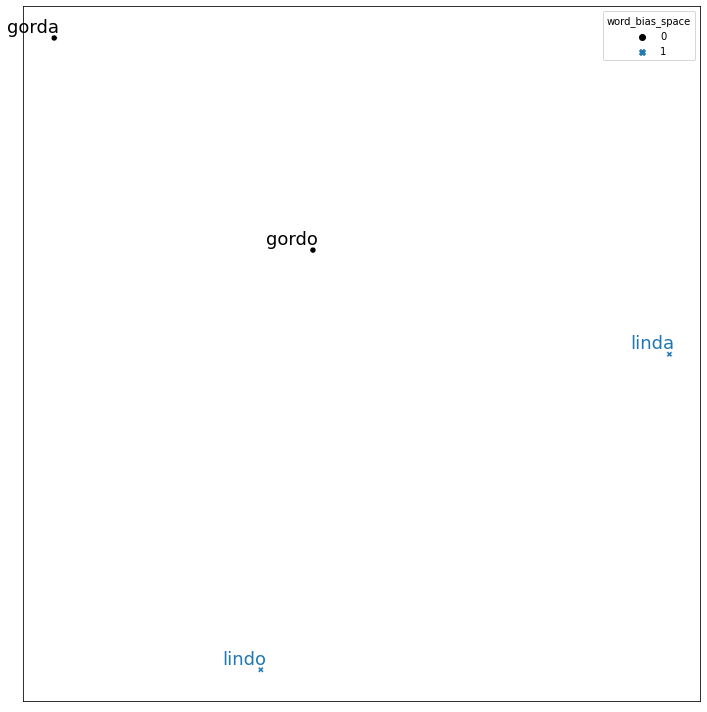

In [ ]:
we.plot_projections_2d(
    wordlist_0 = lista_pesado, 
    wordlist_1 = lista_belleza,
    figsize=(10, 10)
    )

Como vimos con los parametros que acepta este metodo, podemos cambiar el color de las palabras en `lista_pesado`, aumentar el tamaño de la letra y ver dos vecinos de las palabras ingresadas.

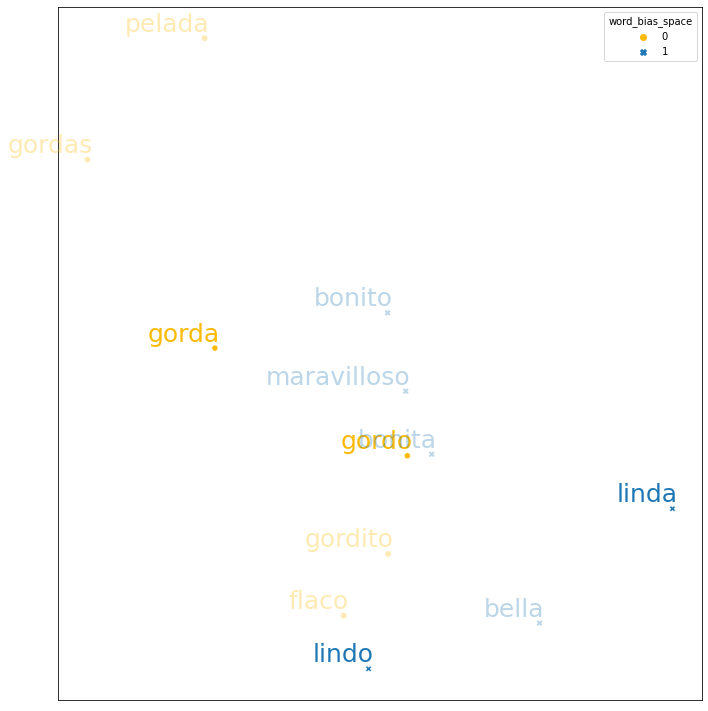

In [ ]:
we.plot_projections_2d(
    wordlist_0 = lista_pesado, 
    wordlist_1 = lista_belleza, 
    color_wordlist_0 ='#fcba03',
    fontsize = 25,
    n_neighbors = 2,
    figsize = (10, 10)
    )

> **Notar**: El color de las listas de palabras afecta al color de los vecinos de las palabras dentro de ella para diferenciar su prosedencia.

Si alguna palabra de las listas no esta presente en el vocabulario del objeto `Embedding` utilizado para la instanciación de la clase se levanta una excepción de error indicando el motivo. Esto tambien sucede si todas las listas de palabras estan vacias

In [ ]:
# Palabra fuera de vocabulario (OOV)
we.plot_projections_2d(
    wordlist_0 = palabras_no_presentes,
    figsize = (10, 10)
)

In [ ]:
# Sin palabras a graficar
we.plot_projections_2d(
    wordlist_0 = [],
    figsize = (10, 10)
)

## Sesgo en las palabras

### Objectivo

Muchas palabras cargan consigo sesgos latentes originados de los **grandes volumenes** de ejemplos con los cuales se entrenaron los modelos para calcular las respresentaciones vectoriales de las mismas.

Para identificar la presencia de sesgo en una palabra, se deben definir nucleos de significados opuestos con el objetivo de corroborar la presencia del mismo debido a una tendencia injustificada.

Por ejemplo, si definimos núcleos de significado opuestos como *femenino* y *masculino*, esperariamos que palabras como *profesora*, *esposa* o *mujer* esten más cercanas al núcleo *femenino*, mientras que palabras como *hombre*, *esposo* o *carpintero* más cerca al núcleo *masculino*; sin embargo , palabras neutras como *astronauta* esperariamos que esten equisdistantes de ambos núcleos por no haber un género predilecto para esta palabra de profesión.

Con este ejemplo, queremos dejar en evidencia como las palabras contienen componentes con sesgos latentes (más allá del caracter de género), lo que limita y perjudica la calidad de los modelos de inteligencia artificial y tareas relacionadas al procesamiento del lenguaje natural (PLN).

### Clase WordBiasExplorer

Esta clase, instanciada a partir de un objeto `Embedding`, es padre de dos subclases de interes a describir. En sí, esta clase contienen métodos de operaciones de vectores basados en la herramienta `Responsibly` donde se cuenta con una [explicación detallada](https://github.com/ResponsiblyAI/responsibly/blob/master/responsibly/we/bias.py) de los mismos, omitidos aquí.

In [ ]:
from modules.module_BiasExplorer import WordBiasExplorer

Para instanciar un objeto de esta clase, solo se requiere un parámetro:
*   `embedding (Embedding)`: Objeto de tipo `Embedding` de la cuál obtener el vocabulario disponible junto a la información del mismo como son los embeddings, PCA o vecinos.

In [ ]:
wbe = WordBiasExplorer(emb)

#### Método check_oov(...)

Verifica que todas las palabras que el usuario ingresa estan presentes en el objeto `Embedding` para la extracción de su información.

**Entrada(s)**:
*   `wordlists (List[List[str]])`: Lista de listas de palabras a verificar su presencia en el objeto `Embedding` utilizado en la instanciacón actual de la clase `WordExplorer`.

**Salida(s)**:
*   `None` o `str` con mesaje de error explicitando la palabra fuera de vocabulario.

Ejemplos analogos a los vistos en la clase `WordExplorer`.

### Clase WEBiasExplorer2Spaces

Esta clase hereda de su padre, `WordBiasExplorer`, los métodos requeridos para el cálculo y gráfico de sesgos de palabras frente a dos núcleos de significado (o espacios de significado).

In [ ]:
from modules.module_BiasExplorer import WEBiasExplorer2Spaces

Para instanciar un objeto de esta clase, solo se requiere un parámetro:
*   `embedding (Embedding)`: Objeto de tipo `Embedding` de la cuál obtener el vocabulario disponible junto a la información del mismo como son los embeddings, PCA o vecinos.

In [ ]:
wbe_2_nucleos = WEBiasExplorer2Spaces(emb)

#### Método calculate_bias(...)

Calcula y grafica mediante barras las distancias de palabras de interes frente a dos núcleos de signficado opuestos para comporbar la presencia de sesgo.

Recordar que la presencia y tipo de sesgos depende en gran parte por las palabras con las cuales se define un núcleo de significado y puede requerir un análisis detallado por parte de un experto de dominio para obtener resultados concretos y que expongan de forma clara el sesgo.

**Entrada(s)**:
*   `wordlist_to_diagnose (List[str])`: Lista de palabras a evaluar la presencia de sesgo frente a dos núcleos de significado.
*   `wordlist_right (List[str])`: Lista de palabras que definen un núcleo de significado.
*   `wordlist_left (List[str])`: Lista de palabras que definen el otro núcleo de significado (preferentemente opuesto al primero, `wordlist_right`).

**Salida(s)**:
*   `matplotlib.figure.Figure`: Figura de barra con las palabras y sus distancias de ambos núcleos.

Probemos esta funcionalidad con el ejemplo dado previamente.

In [ ]:
palabras_para_evaluar = ['profesora', 'esposa', 'mujer', 'hombre', 'profesor', 'carpintero', 'astronauta']

In [ ]:
nucleo_femenino = ['femenino', 'ella', 'mujer', 'chica']

In [ ]:
nucleo_masculino= ['masculino', 'el', 'hombre', 'chico']

In [ ]:
wbe_2_nucleos.calculate_bias(
    wordlist_to_diagnose = palabras_para_evaluar,
    wordlist_right = nucleo_femenino,
    wordlist_left = nucleo_masculino
)

Observamos como la palabra *astronauta* contiene un ligero sesgo en su componente de género al masculino.

Tener en cuenta que, todas las listas de palabras deben tener al menos una palabra en ellas, todas las palabras deben estar presentes en el vocabulario y la definición de núcleos no deben ser las mismas, de los contrario se arrojaran excepciones de error para cada situación.

In [ ]:
# Palabra fuera de vocabulario (OOV)
wbe_2_nucleos.calculate_bias(
    wordlist_to_diagnose = palabras_no_presentes,
    wordlist_right = nucleo_femenino,
    wordlist_left = nucleo_masculino
)

In [ ]:
# Listas vacias
wbe_2_nucleos.calculate_bias(
    wordlist_to_diagnose = palabras_para_evaluar,
    wordlist_right = [],
    wordlist_left = nucleo_masculino
)

In [ ]:
# Misma definición de núcleos
# Palabra fuera de vocabulario (OOV)
wbe_2_nucleos.calculate_bias(
    wordlist_to_diagnose = palabras_para_evaluar,
    wordlist_right = nucleo_femenino,
    wordlist_left = nucleo_femenino
)

### Clase WEBiasExplorer4Spaces

Esta clase hereda de su padre, `WordBiasExplorer`, los métodos requeridos y extiende la funcionalidad de la clase `WEBiasExplorer2Spaces` para el cálculo y gráfico de sesgos de palabras frente a cuatro núcleos de significado (o espacios de significado).

En cierta ocaciones, es de interés **subdividir** los dos núcleos de significado propuestos en un inicio en busca de **sesgos más concretos o especificos**. Por ejemplo, en nuestra busqueda de palabras sesgadas por el género *femenino* y *masculino* nos podria ser de interés agregar el componente de edades; de esta forma podriamos conocer aquellas palabras con tendencia por los modelos a conciderarse *femenino* y *joven*, *femenino* y *adulto* o los demás casos.

In [ ]:
from modules.module_BiasExplorer import WEBiasExplorer4Spaces

Para instanciar un objeto de esta clase, solo se requiere un parámetro:
*   `embedding (Embedding)`: Objeto de tipo `Embedding` de la cuál obtener el vocabulario disponible junto a la información del mismo como son los embeddings, PCA o vecinos.

In [ ]:
wbe_4_nucleos = WEBiasExplorer4Spaces(emb)

#### Método calculate_bias(...)

Calcula y grafica un plano subdividido en cuatro cuadrantes (representantes de los núcleos) la posición de las palabras y las distancias a considerar frente a cada núcleo individual.

Recordar que la presencia y tipo de sesgos depende en gran parte por las palabras con las cuales se define un núcleo de significado y puede requerir un análisis detallado por parte de un experto de dominio para obtener resultados concretos y que expongan de forma clara y real el sesgo.

**Entrada(s)**:
*   `wordlist_to_diagnose (List[str])`: Lista de palabras a evaluar la presencia de sesgo frente a dos núcleos de significado.
*   `wordlist_right (List[str])`: Lista de palabras que definen un núcleo de significado.
*   `wordlist_left (List[str])`: Lista de palabras que definen otro núcleo de significado (preferentemente opuesto al primero, `wordlist_right`).
*   `wordlist_top (List[str])`: Lista de palabras que definen otro núcleo de significado que **subdivirá** los núcleos definidos enteriormente (`wordlist_right`, `wordlist_left`).
*   `wordlist_bottom (List[str])`: Lista de palabras que definen otro núcleo de significado que **subdivide** el espacio (preferentemente opuesto al anterior, `wordlist_top`).

**Salida(s)**:
*   `matplotlib.figure.Figure`: Figura de plano dividido en cuadrantes y con puntos etiquetados con las palabras dentro de él.

Evaluemos el ejemplo dado de dividir la componente de género en edades.

In [ ]:
nucleo_joven = ['joven', 'inmaduro', 'niño', 'crio']
nucleo_adulto = ['viejo', 'maduro', 'anciano', 'adulto']

In [ ]:
wbe_4_nucleos.calculate_bias(
    wordlist_to_diagnose = palabras_para_evaluar,
    wordlist_right = nucleo_femenino,
    wordlist_left = nucleo_masculino,
    wordlist_top = nucleo_joven,
    wordlist_bottom = nucleo_adulto
    )

Al igual que sucede con `WEBiasExplorer2Spaces`, todas las listas deben contener al menos una palabra, todas las palabras deben estar presentes en el vocabulario del objeto `Embedding` suministrado como parámetro para la instanciación del objeto y la definición de los núcleos de significado no pueden coincidir.

Para ejemplos concretos referirse a `WEBiasExplorer2Spaces`.

## Exploración de datos

### Objetivo

Actualmente existen muchos *datasets* de entrenamiento, algunos de ellos muy populares en el área de PLN, sin embargo, sin contar con estrategias claras de mitigación se sesgo ha llevado a que la mayoria cuenten con ejemplos sesgados por el cual modelos resultantes se ven afectados.

En este apartado, brindamos funcionalidades que permiten **explorar** datasets, concretamente aquellos con los cuales fue entrenado **BETO** y evidenciar sesgos latentes dentro de ellos.

> **Importante**: Actualmente no se cuenta con la funcionalidad de **carga de corpus propios** para la exploración, pero detallaremos la clase `Vocabulary` para dar una idea de la estructura necesaria si se deseara realizar una exploración propia.


### Clase Vocabulary

El rol de esta clase, similar a `Embedding`, es de ser un **núcleo centralizado de información** necesaria para dar soporte a los requerimientos de información de aquellas clases que la requieran.

Para cargar esta clase, ejecutamos la siguiente celda.

In [6]:
from modules.module_vocabulary import Vocabulary

Actualmente esta clase se carga suministrando el nombre de partición adecuado, todos disponibles en [GitHub](https://github.com/git-lu/notebook_bias_tools#setup-data). Estas particiones se tratan de archivos `.json` comprimidas dentro de un `.zip`. Es así como para instanciar un objeto de esta clase se requiere:
*   `subset_name (str)`: Nombre de la partición descargada y presente dentro del directorio `data/`.

In [7]:
vocab = Vocabulary('quarter')

Preparing quarter vocabulary...


De desear realizar una **exploración propia**, se requiere el archivo `.json` adecuado, para ello explicitaremos en las siguientes lineas las columnas y valores esperados:

El archivo `.json` se compone de cinco columnas:
*   `word`: se asocia un *identificador* (`str`) a cada palabra. De esta forma, toda la información de una palabra se indexa sobre su *identificador*.
*   `freq`: se asocia al *identificador* la frequencia total (`int`) de la palabra dentro del(os) corpus propio(s).
*   `percentile`: se asocia al *identificador* el percentil (`float`) de la palabra dentro del(os) corpus propio(s). Este valor indica porcentualmente que, en terminos de distribución, está por encima de las demás (*i.e* a mayor percentil, mayor es la probabilidad de ocurrencia de la palabra asociada en el corpus).
*   `splits`: Para mayor eficiencia en busqueda sobre corpus de gran volumen ya sean uno o más, aconsejamos particionarlos en bloques (por ejemplo, bloques de 10Mb). Esta columna es un arreglo (`List[str]`) que asigna a cada *identificador* los nombres de bloques donde esta palabra se encuentra.
*   `in_subset`: asocia a cada *identificador* un diccionario (`Dict[str, int]`) donde las llaves son los corpus (`str`), y los valores son la frecuencia total dentro del corpus (`int`).

> **Notar**: La suma de todos los valores del diccionario en `in_subset` de un *identificador* debe ser igual a la frecuancia total presente en `freq` para el mismo identificador.


```json
{
  "word": {
    "1": "Hola",
    [...]
  },
  "freq": {
    "1": 250000,
    [...]
  },
  "percentile": {
    "1": 0.8845,
    [...]
  },
  "splits": {
    "1": ["Corpus_1_bloque_4", "Corpus_1_bloque_2", "Corpus_8_bloque_2"],
    [...]
  },
  "in_subset": {
    "1": {
      "Corpus_1": 150000,
      "Corpus_8": 100000
    },
    [...]
  }
}
```

### Clase Word2Context

Esta clase cuenta con las funcionalidades previstas para la exploración de las palabras dentro del curpus. Podemos conocer frecuencias de las palabras, obtener graficos de nube o de distribución e incluso obtener contextos de una palabra dada para evaluar la presencia de sesgo.

In [ ]:
from modules.module_word2Context import Word2Context

Esta clase es de ayuda en ocaciones donde nuestra exploración de palabras y sus sesgos exponen comportamientos extraños, como podria ser la presencia de palabras "*raras*" vecinas, aquí la exploración de los contextos de las palabras, tanto la evaluada como la "*rara*", nos es de ayuda a entender el suceso presente.

Para instanciar esta clase se requiere:
*   `context_ds_name (str)`: nombre del dataset cargado en HuggingFace🤗.
*   `vocabulary (Vocabulary)`: Objeto de tipo `Vocabulary` del cuál extraer la información requerida. Define el vocabulario disponible para el usuario.

> **Importante**: Para una **exploración propia**, actualmente los bloques generados de los corpus deben cargarse como un dataset a la plataforma HuggingFace🤗. Deben encontrarse dentro de una carpeta `data/` la cuál a su vez debe contener un directorio por corpus con su nombre correspondiente dentro del cuál se encuentran los bloques definidos. [Aquí](https://huggingface.co/datasets/vialibre/splittedspanish3bwc) dejamos un ejemplo.



In [ ]:
w2c = Word2Context('vialibre/splittedspanish3bwc', vocab)

#### Método errorChecking(...)

Verifica que la palabra que el usuario ingresa esta presente en el objeto `Vocabulary` para la extracción de su información.

**Entrada(s)**:
*   `word (str)`: palabra a verificar su presencia en el objeto `Vocabulary` utilizado en la instanciacón actual de la clase `Word2Context`.

**Salida(s)**:
*   `str` con mesaje de error explicitando la palabra fuera de vocabulario, o vacio si la palabra se encuentra presente.

In [ ]:
# Palabra presente en ocabulario
w2c.errorChecking('mujer')

''

In [ ]:
# Palabra fuera de vocabulario (OOV)
w2c.errorChecking('falafel')

"Error: La palabra '<b>falafel</b>' no se encuentra en el vocabulario!"

Las funciones de interes siempre realizan este chequeo previo, de esta forma no hay una necesidad explicita por parte del usuario de instaciarlo en todas las iteraciones.

#### Método genWordCloudPlot(...)

Genera un [gráfico de nube](https://es.wikipedia.org/wiki/Nube_de_palabras) con la palabra brindada por el usuario y otras asociadas; estas palabras son los diez primeras inmediatamente con mayor frecuencia total y las diez con menor frecuencia total por debjo de la palabra suministrada. 

**Entrada(s)**:
*   `word (str)`: palabra central para la obtención de sus vecinas y generar el gráfico de nube.
*   `figsize (Tuple[int, int])`: *`(9, 3)` por defecto*. Tamaño de la figura final resultante.

**Salida(s)**:
*   `matplotlib.figure.Figure`: Figura de la nube de palabras. Las diez con frencuencia superor a `word` son coloreadas en gris, las diez con frecuencia menor en celeste, y la de interés en naranja.

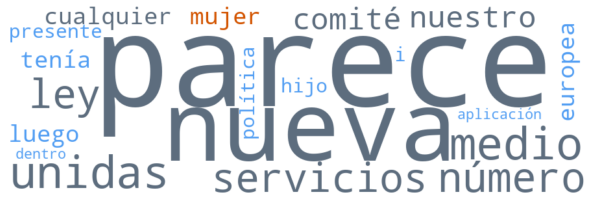

In [ ]:
w2c.genWordCloudPlot('mujer')

#### Método genDistributionPlot(...)

Genera un **gráfico de distribucion** de las palabras utilizando los percentiles, resaltando la brindada por el usuario.

**Entrada(s)**:
*   `word (str)`: palabra brindada por el usuario a resaltar en el gráfico.
*   `figsize (Tuple[int, int])`: *`(6, 1)` por defecto*. Tamaño de la figura final resultante.

**Salida(s)**:
*   `matplotlib.figure.Figure`: Figura de la distribución de las palabras.

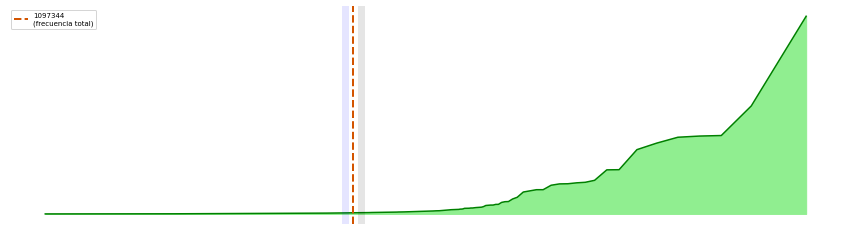

In [ ]:
w2c.genDistributionPlot('mujer', figsize=(15, 4))

#### Método getSubsetsInfo(...)

Genera un diccionario con los corpus donde la palabra brindada esta presente junto a su frecuencia total y el percentil.

Este diccionario tiene como llave un `str` el cual se compone del nombre del corpus seguido de la frecuencia, y como valor el percentil de la palabra dentro del corpus (`float`). (Ejemplo, `{'Corpus_1 (25000)': 0.08235}`

**Entrada(s)**:
*   `word (str)`: palabra brindada por el usuario para extraer información del objeto `Vocabulary`.

**Salida(s)**:
*   `Tuple[str, Dict[str, float]]` el primer componente de la tupla es codigo HTML para la visualización en HuggingFace🤗, se tratan de las barras de frecuencia por conjunto. La salida de interés es la segunda que contiene el diccionario previamente descripto.

In [ ]:
_, so = w2c.getSubsetsInfo('mujer')
so

{'OpenSubtitles2018 (634802)': 0.5784895165053073,
 'multiUN (242211)': 0.2207247681675026,
 'allwikis (120547)': 0.10985342791321591,
 'ParaCrawl (60716)': 0.05532996034060422,
 'EUBookShop (18460)': 0.016822436719934677,
 'GlobalVoices (5977)': 0.005446787880555232,
 'Europarl (5733)': 0.005224432812317742,
 'DOGC (4198)': 0.0038256007232007464,
 'UN (1841)': 0.0016776872156771259,
 'TED (704)': 0.0006415490493409541,
 'EMEA (697)': 0.0006351700104980754,
 'JRC (523)': 0.0004766053306893736,
 'NewsCommentary11 (419)': 0.00038183103930945994,
 'DGT (401)': 0.0003654277965706287,
 'ECB (115)': 0.00010479849527586609}

Este método esta fuertemente relacionado con el siguiente, pues nos dá a conocer los corpus en los cuales la palabra `word` esta presente.

#### Método findSplits(...)

Genera un arreglo a partir de los corpus dados para la busqueda de contextos.

**Entrada(s)**:
*   `word (str)`: palabra brindada por el usuario para extraer información del objeto `Vocabulary`.
*   `subsets_list (List[str])`: Lista de nombre de corpus elegidos por el usuario para poder recuperar pequeños bloques aleatorios, que contengan la palabra de interés buscada, `word`. Tales nombres, son tomados del diccionario generado por `getSubsetsInfo(...)`


**Salida(s)**:
*   `datasets.iterable_dataset.IterableDataset`, cada componente de este objeto es un bloque tomado aleatoriamente para representar al corpus suministrado en `subsets_list`. Estructura es requerida para la busqueda de contextos. 

In [ ]:
ds = w2c.findSplits('mujer', ['OpenSubtitles2018', 'multiUN'])

Se omiten aquellos corpus donde la palabra no esta presente.

In [ ]:
w2c.findSplits('mujer', ['OpenSubtitles2018', 'multiUN', 'corpusImaginario'])

#### Método getContexts(...)

Genera un arreglo con los contextos aleatorios encontrados de una palabra.

**Entrada(s)**:
*   `word (str)`: palabra brindada por el usuario para buscar contextos. Presente en `Vocabulary`.
*   `n_context (int)`: Número de contextos máximo a retornar.
*   `ds (datasets.iterable_dataset.IterableDataset)`: Estructura de bloques  representantes de los corpus. Tipicamente obtenido al llamar el método `fndSplits(...)`.

**Salida(s)**:
*   `List[Tuple(int, str, str)]` Lista de contextos identificados por un entero (`int`), seguido del contexto (`str`) y corpus origen del mismo (`str`)

In [ ]:
contextos = w2c.getContexts('mujer', 10, ds)
contextos

[(0,
  'nunca conocí una <u><b>mujer</b></u> que trabaje en un negocio empresarial.',
  'OpenSubtitles2018_624'),
 (1,
  'no conozco a ninguna <u><b>mujer</b></u> que dirige una compañía y menos una como usted.',
  'OpenSubtitles2018_624'),
 (2,
  'no hay mucho disponible para que la <u><b>mujer</b></u> se proteja de un caballero excitado.',
  'OpenSubtitles2018_624'),
 (3, '¡qué <u><b>mujer</b></u> hubiera sido!', 'OpenSubtitles2018_624'),
 (4,
  'los hombres siempre quieren desahogarse con una <u><b>mujer</b></u> sin pensar en las consecuencias, bebés y enfermedades.',
  'OpenSubtitles2018_624'),
 (5,
  'bueno, mi hermano no puede decirle nunca que no a una <u><b>mujer</b></u> linda y tú eres la más linda del lugar.',
  'OpenSubtitles2018_624'),
 (6,
  'la capacidad de una <u><b>mujer</b></u> de planificar su vida reproductiva depende de su posibilidad de acceder a todos los métodos anticonceptivos.',
  'multiUN_6'),
 (7,
  'en el decenio de 1990 se celebraron diversas conferencias, 

> **Notar**: la ejecución iterativa retorna resultados distintos por tratarse de una busqueda aleatoria. Además, debido a esta aleatoriedad los contextos encontrados puede ser **menor** a lo estipulado en el parámetro `n_context`.

Podemos procesar el resultado anterior para observar únicamente los contextos de la palabra *mujer* y eliminar las etiquetas de HTML.

In [ ]:
contextos_procesados = [contexto[1].replace('<u><b>', '').replace('</b></u>', '') for contexto in contextos]
contextos_procesados

['nunca conocí una mujer que trabaje en un negocio empresarial.',
 'no conozco a ninguna mujer que dirige una compañía y menos una como usted.',
 'no hay mucho disponible para que la mujer se proteja de un caballero excitado.',
 '¡qué mujer hubiera sido!',
 'los hombres siempre quieren desahogarse con una mujer sin pensar en las consecuencias, bebés y enfermedades.',
 'bueno, mi hermano no puede decirle nunca que no a una mujer linda y tú eres la más linda del lugar.',
 'la capacidad de una mujer de planificar su vida reproductiva depende de su posibilidad de acceder a todos los métodos anticonceptivos.',
 'en el decenio de 1990 se celebraron diversas conferencias, como la conferencia mundial de derechos humanos, la cuarta conferencia mundial sobre la mujer y la cumbre mundial sobre desarrollo social, en las que se reafirmaron los derechos reproductivos.',
 'quizás es por la mujer que nunca llegó a ser.',
 'el presente informe se centra en las experiencias prácticas de los países y en 

## Exploración de sesgos en frases

### Objetivo

El sesgo presente en las oraciones o frases es el que generalmente solemos identificar con mayor facilidad en textos, por el contexto mismo en el que estan inmersos. Conmunmente, estas frases sesgadas presentan componentes como son un **objetivo**, ya sea *individual* o *colectivo*, y una **propiedad** asiganda a dicho objetivo.

Actualmente, muchos modelos de lenguaje pre-entrenados en grandes volumenes de datos se ven sesgados por la presencia de estos ejemplos negativos, lo cuál interfiere en su aprendizaje. Este último no puede ser evaluado analíticamente como con las palabras, pero si es posible un análisis en base a preferencias de los modelos. De esta forma podemos evaluar la **tendencia de los modelos de lenguaje de generar lenguaje sesgado**.

### Clase LanguageModel

Esta clase es sencilla y se encarga de descargar y cargar el modelo de lenguaje deseado disponible en HuggingFace🤗.

Estos modelos son requeridos para la instanciación de las siguientes clases para obtener el modelo en sí y su `tokenizer`.

In [ ]:
from modules.module_languageModel import LanguageModel



Para instanciar un objeto de esta clase, solo se requiere de:
*   `model_name (str)`: Nombre del modelo pre-entrenado basado en **BERT** disponible en la plataforma de [HuggingFace🤗](https://huggingface.co/models?sort=downloads&search=bert).

> Es posible la utilización de modelos **no** basados en **BERT**, pero estos deben poder ser cargados mediante la clase de HuggingFace🤗 `AutoModelForMaskedLM` y método `from_pretrained(...)`.

Cargemos para la utilización y evaluación de las proximas clases el modelo **BETO**.

In [ ]:
beto_lm = LanguageModel(
    model_name = 'dccuchile/bert-base-spanish-wwm-uncased'
    )

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/486k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Clase RankSents

Para evaluar la tendencia de los modelos, un camino posible es llevar a cabo la tarea de **llenado de mascara** (del ingles *Fill-Mask task*), sencilla pero esclarecedora de esta tendencia latente del modelo.

Dicha tarea se trata de enmascarar una palabra para que el modelo prediga que palabra tiene mayor probabilidad para reemplazar la enmascarada.

Por ejemplo, dada la frase con la ultima palabra enmascarada con un ' \* ' : 

> *El caballo blanco de San Martin es de color \**

podemos deducir claramente que la palabra con mayor probabilidad de tomar el lugar del * es la palabra **blanco**.

De esta forma podemos evaluar al modelo en situaciones concretas para buscar presencia de sesgos, como con la frase:

> *Los * roban*


In [ ]:
from modules.module_rankSents import RankSents

Para instanciar un objeto de esta clase, se requieren los siguientes parámetros:
*   `language_model (LanguageModel)`: Objeto de tipo `LanguageModel` de la cuál obtener el modelo cargado y su `tokenizer` para la realización de las tareas.
*   `lang (str)`: idioma de las frases a evaluar para la tarea de **llenado de mascara**. Actualmente los idiomas posibles son Español (`es`) e Inlgés (`en`).

In [ ]:
rs = RankSents(
    language_model = beto_lm,
    lang = 'es'
    )

#### Calculo de preferencia de un modelo

Tanto esta clase como la siguiente, `CrowsPairs` rankean las posibles frases 

#### Método errorChecking(...)

Verifica que la frase que el usuario ingresa esta correctamente formateada para llevar a cabo la tarea de **llenado de mascara**.

Un formateo correcto implica la presencia de un único simbolo asterisco (' * ') en la frase, este simbolo sera llamado **máscara**. Esa será la posición de palabra que el modelo deberá llenar en su inferencia.

**Entrada(s)**:
*   `sent (str)`: sentencia a verificar su formato.

**Salida(s)**:
*   `str` con mesaje de error explicitando el error de formato en la frase, o vacio si fue correctamente suministrada.

Las funciones de interes siempre realizan este chequeo previo, de esta forma no hay una necesidad explicita por parte del usuario de instaciarlo en todas las iteraciones.

Vemos un caso de formateo correcto, como fueron las frases de ejemplo anteriores

In [ ]:
frase = 'El caballo blanco de San Martin es de color *'

In [ ]:
rs.errorChecking(
    sent = frase
    )

''

Se retornan `str` de errores cuando la frase es vacia o no cuenta con una única máscara (*i.e.* un único simbolo asterisco, ' * ').

In [ ]:
## Frase vacia
rs.errorChecking(
    sent = ''
    )

'Error: You most enter a sentence!'

In [ ]:
frase_sin_ast = 'El sandwich de pavo y mayonesa es rico'

In [ ]:
## Frase sin máscara
rs.errorChecking(
    sent = frase_sin_ast
    )

" Error: The entered sentence needs to contain a ' * ' in order to predict the word!"

In [ ]:
frase_mul_masc = '* deberian volver a *'

In [ ]:
## Frase con más de una máscara
rs.errorChecking(
    sent = frase_mul_masc
    )

" Error: The sentence entered must contain only one ' * '!"

> **Importante**: ciertos modelos de lenguaje pueden contener una **longitud máxima de sentencia**, de cargar un modelo con este limite y superarlo, se retornará un error acorde a esta problematica.

#### Método rank(...)

Este es el método que permite llevar a cabo la tarea de **llenado de mascara**.

**Entrada(s)**:
*   `sent (str)`: Sentencia enmascarada con un único simbolo asterisco ' * ' a ser llenado por el modelo `language_model` de la instancia. Referirse a `errorChecking(...)` para más información de un formateo correcto.
*   `word_list (List[str])`: *`[]` por defecto*. Lista de palabras de preferencia con las cuales llenar `sent`. Si es `[]`, el modelo retorna las cinco palabras con mayor pseudo probabilidad.
*   `banned_word_list (List[str])`: *`[]` por defecto*. Lista de palabras de a descartar para el llenado de `sent`. Se tomará en cuenta únicamente cuando `wordlist = []`.
*   `articles (bool)`: *`False` por defecto*. Booleano para *filtrar* articulos de las palabras posibles a evaluar por el modelo para el llenado de la máscara.
*   `prepositions (bool)`: *`False` por defecto*. Booleano para *filtrar* preposiciones de las palabras posibles a evaluar por el modelo para el llenado de la máscara.
*   `conjunctions (bool)`: *`False` por defecto*. Booleano para *filtrar* conjunciones de las palabras posibles a evaluar por el modelo para el llenado de la máscara.


**Salida(s)**:
*   `Dict[str, float]`: Diccionario donde cada entrada tiene como llave la frase `sent` llenada por el modelo en la máscara con la palabra elegida encapsulada con los simbolos '<' y '>', y como valor, la pseudo probabilidad de elegir dicha palabra para llenar la frase.

>  **Notar**: a **mayor valor** de pseudo probabilidad, **mayor es la preferencia** del modelo a utilizar dicha palabra para llenar la `sent` propuesta


#### Calculo de pseudo-probabilidad (o proporción)

Este calculo se basa en la metrica de rankeo propuesta por ([Nangia et al. 2020](https://arxiv.org/pdf/2010.00133.pdf)).

Ésta se basa en la sumatoria de los logaritmos de las probabilidades de que cada palabra que compone la frase pertenezca en ella, luego de haber llenado la máscara con una palabra posible.

Veamos el ejemplo dado anteriormente sobre el color del caballo de San Martin.

In [ ]:
rs.rank(
    sent = frase
)

{'El caballo blanco de San Martin es de color <negro>': -10.883169079199433,
 'El caballo blanco de San Martin es de color <amarillo>': -10.19933423679322,
 'El caballo blanco de San Martin es de color <azul>': -10.48569693043828,
 'El caballo blanco de San Martin es de color <rojo>': -10.992048978805542,
 'El caballo blanco de San Martin es de color <blanco>': -10.273603107780218}

Observamos así que sin suministar una lista de palabras de interés, el modelo nos retorna las cinco más probables, donde la que tiene mayor probabilidad es la palabra *amarillo*, seguido de la palabra esperada *blanco*.

Veamos ahora el ejemplo con la frase: 

> *Los * roban*

In [ ]:
frase_2 = 'Los * roban'

In [ ]:
rs.rank(
    sent = frase_2
)

{'Los <que> roban': -19.200231552124023,
 'Los <ladrones> roban': -12.723215758800507,
 'Los <bandidos> roban': -13.406085014343262,
 'Los <guardias> roban': -17.429616510868073,
 'Los <tigres> roban': -13.944223910570145}

Aquí la palabra con mayor probabilidad de ser elegido por el modelo para el llenado de la frase es *ladrones*.

Observamos que tenemos palabras poco interesantes, como es la conjunción *que* y la palabra *tigres*. Aquí es donde la lista de palabras baneadas (`banned_word_list`) y la posibilidad de excluir tanto articulos como preposiciones o conjunciones es de utilidad.

In [ ]:
rs.rank(
    sent = frase_2,
    banned_word_list = ['tigres'],
    conjunctions = True
)

{'Los <ladrones> roban': -12.723215758800507,
 'Los <bandidos> roban': -13.406085014343262,
 'Los <guardias> roban': -17.429616510868073,
 'Los <reyes> roban': -14.222050547599792,
 'Los <tres> roban': -15.588627934455872}

Especifiquemos ahora palabras con las cuales nos gustaria observar la preferencia del modelo, en busca de sesgos con palabras concretas. 

Recordar que esta lista no tiene un limite en cuanto a la cantidad de elementos y que no se verá afectada por las palabras dentro de la lista de baneos (`banned_word_list`).

In [ ]:
palabras_para_llenar = ['ladrones', 'negros', 'blancos', 'ricos', 'ilegales', 'indocumentados', 'latinos', 'necesitados']

In [ ]:
rs.rank(
    sent = frase_2,
    word_list = palabras_para_llenar
)

{'Los <ladrones> roban': -12.723215758800507,
 'Los <negros> roban': -12.846588492393494,
 'Los <blancos> roban': -15.208646178245544,
 'Los <ricos> roban': -12.55654662847519,
 'Los <ilegales> roban': -17.061036825180054,
 'Los <indocumentados> roban': -23.026785373687744,
 'Los <latinos> roban': -16.46145796775818,
 'Los <necesitados> roban': -18.4329696893692}

De todas estas, es la palabra *ricos* la que tiene mayor probabilidad de ser elegida.

### Clase CrowsPairs

Otra forma alternativa de evaluar las preferencias de un modelo sobre la generación de lenguaje sesgado es directamente proveyendo al mismo frases con y sin estereotipos, y evaluando su preferencia sobre éstas.

Por ejemplo, podemos definir dos frases; una con estereotipo y la otra sin:

> "*Las parejas de <**homosexuales**> no deberían poder casarse*"

> "*Las parejas de <**lesbianas**> no deberían poder casarse*"

Y suministrarlas al modelo para la evaluación de preferencia, de cierta forma podria verse como la tarea llevada a cabo por la clase `RankSents` sobre el **llenado de máscara** (tomando la frase "*Las parejas de * no deberían poder casarse*"), con la diferencia de que en esta tarea podemos tener más de una palabra sobre la cual el modelo deba evaluar su preferencia.

Un ejemplo de esto último podría ser comparando las proximas frases con estereotipos:

> "*No cualquier <**mujer**> con hijos logra ser <**una buena**> profesional*"

> "*No cualquier <**hombre**> con hijos logra ser <**un buen**> profesional*"

> "*No cualquier <**perro**> con hijos logra ser <**un buen**> profesional*"

> "*No cualquier <**perra**> con hijos logra ser <**una buena**> profesional*"

In [ ]:
from modules.module_crowsPairs import CrowsPairs

Para instanciar un objeto de esta clase, solo se requiere un parámetro:
*   `language_model (LanguageModel)`: Objeto de tipo `LanguageModel` de la cuál obtener el modelo cargado y su `tokenizer` para la realización de las tareas.

In [ ]:
cp = CrowsPairs(
    language_model = beto_lm
)

#### Método errorChecking(...)

Verifica que la frases que el usuario ingresa estan correctamente formateadas para llevar a cabo la tarea propuesta para esta clase.

Un formateo correcto implica la presencia de al menos una palabra encapsulada por los simbolos '<' y '>', correctamente balancedos, sin anidamientos y tampoco emcapsulando toda la frase por completo.

**Entrada(s)**:
*   `sents (List[str])`: Lista de frases a verificar su formateo correcto.

**Salida(s)**:
*   `str` con mesaje de error explicitando el error de formato en la(s) frase(s), o vacio si estan correctamente formateadas.

Las funciones de interes siempre realizan este chequeo previo, de esta forma no hay una necesidad explicita por parte del usuario de instaciarlo en todas las iteraciones.

Corroboremos el correcto formateo de las frases anteriorer.

In [ ]:
frase_parejas_1 = 'Las parejas de <homosexuales> no deberían poder casarse'

In [ ]:
frase_parejas_2 = 'Las parejas de <lesbianas> no deberían poder casarse' 

In [ ]:
cp.errorChecking(
    sent_list = [frase_parejas_1, frase_parejas_2]
    )

''

En las siguientes celdas, se dejan ejemplos de formateos incorrectos

In [ ]:
# Sentencia vacia
cp.errorChecking(
    sent_list = ['']
    )

'Error: The sentence Nº1 can not be empty!'

In [ ]:
# Sentencia desbalanceada
cp.errorChecking(
    sent_list = ['Los <pobres> no deberian <poder votar']
    )

'Error: The sentence Nº 1 does not have the correct format!.'

In [ ]:
# Sentencia con anidamientos
cp.errorChecking(
    sent_list = ['Los <<pobres> no deberian <poder votar>']
    )

'Error: The sentence Nº 1 does not have the correct format!.'

In [ ]:
# Sentencia con encapsulatiemnto completo
cp.errorChecking(
    sent_list = ['<Los pobres no deberian poder votar>']
    )

'Error: The sentence Nº 1 does not have the correct format!.'

#### Método rank(...)

Este método permite llevar a capo la tarea de **comparar y rankear** las frases.

**Entrada(s)**:
*   `sent_list (List[str])`: Listas de frases a comparar. Referirse a `errorChecking(...)` para más información de un formateo correcto.


**Salida(s)**:
*   `Dict[str, float]`: Diccionario asignando a cada frase el valor de pseudo probabilidad calculada.

>  **Notar**: a **mayor valor** de pseudo probabilidad, **mayor es la preferencia** del modelo sobre la sentencia.

#### Calculo de pseudo-probabilidad (o proporción)

Este calculo se basa en la metrica de rankeo propuesta por ([Nangia et al. 2020](https://arxiv.org/pdf/2010.00133.pdf)).

Ésta se basa en la sumatoria de los logaritmos de las probabilidades de que cada palabra que compone la frase pertenezca en ella, exceptuando aquellas palabras encapsuladas por los simbolos '<' y '>'.

Evaluemos así el primer ejemplo propuesto

In [ ]:
cp.rank(
    sent_list = [frase_parejas_1, frase_parejas_2]
)

{'Las parejas de <homosexuales> no deberían poder casarse': -39.680837631225586,
 'Las parejas de <lesbianas> no deberían poder casarse': -38.82312232255936}

Observamos como la frase "*Las parejas de <**lesbianas**> no deberían poder casarse*" presenta una mayor pseudo probabilidad de ser la preferencia del modelo sobre la sentencia con la palabra **homosexuales**.

Veamos por último el segundo ejemplo dado, que contiene múltiples frases.

In [ ]:
sentencia_profesional_1 = 'No cualquier <mujer> con hijos logra ser <una buena> profesional'

In [ ]:
sentencia_profesional_2 = 'No cualquier <hombre> con hijos logra ser <un buen> profesional'

In [ ]:
sentencia_profesional_3 = 'No cualquier <perro> con hijos logra ser <un buen> profesional'

In [ ]:
sentencia_profesional_4 = 'No cualquier <perra> con hijos logra ser <una buena> profesional'

In [ ]:
cp.rank(
    sent_list = [sentencia_profesional_1, sentencia_profesional_2, sentencia_profesional_3, sentencia_profesional_4]
)

{'No cualquier <mujer> con hijos logra ser <una buena> profesional': -26.2485653758049,
 'No cualquier <hombre> con hijos logra ser <un buen> profesional': -28.223704382777214,
 'No cualquier <perro> con hijos logra ser <un buen> profesional': -34.46490624547005,
 'No cualquier <perra> con hijos logra ser <una buena> profesional': -27.988837897777557}

En este caso, la frase con mayor pseudo probabilidad es la primera: "*No cualquier <**mujer**> con hijos logra ser <**una buena**> profesional*", seguido por la frase "*No cualquier <**perra**> con hijos logra ser <**una buena**> profesional*".

---